# Modelos para prueba
En este notebook se probaran tres modelos mas, a ver si se pueden llegar a mejorar las metricas de evaluación del modelo 

In [11]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,make_scorer,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import warnings

In [12]:
print("version de numpy",np.__version__)
print("version de pandas",pd.__version__)
print("version de skelarn",sklearn.__version__)
print("version de matplotlib",matplotlib.__version__)
print("version de")
!python3 --version

version de numpy 1.23.5
version de pandas 1.5.2
version de skelarn 1.2.2
version de matplotlib 3.6.2
version de
Python 3.10.7


## Carga y preprocesdamiento de datos
---
Para el preprocesamiento de datos, la selección de caracteristicas y la transformación se utilizaran las funciones creadas para este fin.
Carguemos los datos

In [13]:
ruta_train=r"/home/leomorya/proyecto_final_metodologias/data/train.csv"
# cargando los datos 
df_train = pd.read_csv(ruta_train)
df_train.head()

,ID,Edad,Tipo_Trabajo,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Mes,...,Campana,Dias_Ultima_Camp,No_Contactos,Resultado_Anterior,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,57,servicios,casado,bachillerato,unknown,no,no,telefono fijo,may,...,1,999,0,sin contacto,1.1,93994.0,-36.4,4857.0,5191.0,0
1,2,37,servicios,casado,bachillerato,no,si,no,telefono fijo,may,...,1,999,0,sin contacto,1.1,93994.0,-36.4,4857.0,5191.0,0
2,3,40,administrador negocio,casado,primaria,no,no,no,telefono fijo,may,...,1,999,0,sin contacto,1.1,93994.0,-36.4,4857.0,5191.0,0
3,4,56,servicios,casado,bachillerato,no,no,si,telefono fijo,may,...,1,999,0,sin contacto,1.1,93994.0,-36.4,4857.0,5191.0,0
4,7,25,servicios,single,bachillerato,no,si,no,telefono fijo,may,...,1,999,0,sin contacto,1.1,93994.0,-36.4,4857.0,5191.0,0


Cargamos las funciones de preprocesamiento, selección de caracteristicas y transformación

In [14]:
#llamamos los paquetes
import sys
# colocamos la ruta del paquete a python 
sys.path.append('/home/leomorya/proyecto_final_metodologias/tdsp_template/src/nombre_paquete/')

In [15]:
from preprocessing.funcion_de_preprocesamiento import preprocesamiento
from preprocessing.seleccion_caracteristicas import seleccion_caracteristicas
from preprocessing.transformaciones_datos import transformaciones

In [16]:
# preprocesamos
df_train_prep = preprocesamiento(df_train)
# seleccionamos caracteristicas 
df_train_prep_selec = seleccion_caracteristicas(df_train_prep,"train")
# transformamos los datos listos para modelar
datos_finales = transformaciones(df_train_prep_selec)
datos_finales

array([[0.        , 0.        , 0.        , ..., 0.60251046, 0.14022145,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.60251046, 0.14022145,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.60251046, 0.14022145,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.999987  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.999987  ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.999987  ,
        0.        ]])

## Organización de variables endogenas (dependientes) y exogenas (independientes)

In [17]:
# exogenas 
X = datos_finales[:, :-1]
# endogenas
y = datos_finales[:, -1:].flatten()

## Pariticionamiento en datos de entrenamiento y prueba
---
Para esto utilizaraemos sklearn 

In [18]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        test_size=0.33, random_state=42,stratify=y)

# Modelos a probar
Los modelos que se utilizaran son Random forest, maquina de soporte vectorial y perceptron multicapa. 

recordemos que los datos tienes desbalance

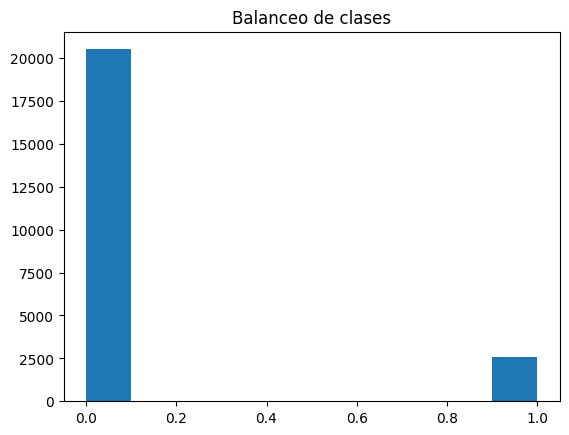

In [21]:
plt.hist(y)
plt.title("Balanceo de clases")
plt.show()

# Busqueda de hiperparametros
---
Para la busqueda de los mejores hiperparametros del modelo se utilizara GridSearchCV.

 ### 1.Modelo Random forest
---
Los hiperparametros son 

In [34]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [35]:
param_grid_RF={'class_weight': ["balanced",None,
                                "balanced_subsample"],
               'criterion': ['gini',"entropy"],
                'max_depth': [10,20,50],
                'max_leaf_nodes': [5,10,20,50],
                'n_estimators': [50,100,200],
                "random_state":[0,42],
                "max_features":["sqrt", "log2"],            
              }

In [36]:
%%time
gsearch = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=param_grid_RF,
        scoring=make_scorer(f1_score, greater_is_better=True),
        n_jobs=-1,
        cv=10
        ).fit(X_train, y_train)

CPU times: user 9.73 s, sys: 1.53 s, total: 11.3 s
Wall time: 14min 50s


Veamos los mejores parametros

In [37]:
gsearch.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 50,
 'n_estimators': 50,
 'random_state': 0}

imprimamos el reporte de las metricas 

In [39]:
mejor_modelo=gsearch.best_estimator_
y_pred=mejor_modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      6768
         1.0       0.38      0.63      0.47       855

    accuracy                           0.84      7623
   macro avg       0.66      0.75      0.69      7623
weighted avg       0.89      0.84      0.86      7623



Entrenamiento del modelo con todos los datos de train

Aca ya no se realizara la cros validación sino se utilizaran todos los datos


In [41]:
mejores_parametros_rf={'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 50,
 'n_estimators': 50,
 'random_state': 0}

In [46]:
mejor_modelo_rf = RandomForestClassifier(**mejores_parametros_rf)
mejor_modelo_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_leaf_nodes=50, n_estimators=50,
                       random_state=0)

In [47]:
y_pred = mejor_modelo_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      6768
         1.0       0.38      0.63      0.47       855

    accuracy                           0.84      7623
   macro avg       0.66      0.75      0.69      7623
weighted avg       0.89      0.84      0.86      7623



Ahora su matriz de confusión 

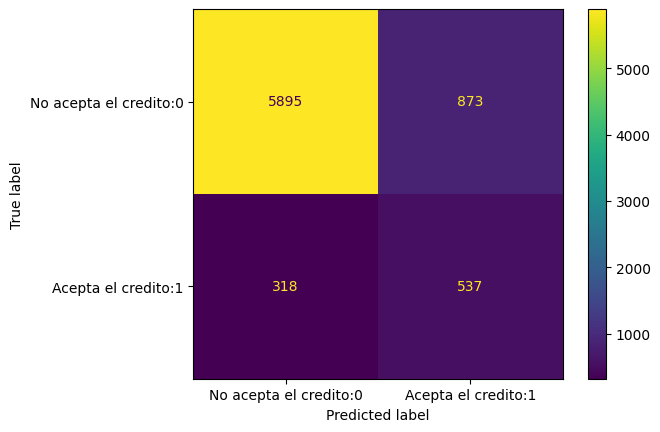

In [49]:
cm = confusion_matrix(y_test, y_pred,labels=mejor_modelo_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No acepta el credito:0","Acepta el credito:1"])
disp.plot()
plt.show()

Guardando el modelo

In [50]:
# ruta
ruta_1 = "/home/leomorya/proyecto_final_metodologias/tdsp_template/src"
ruta_2 = "/nombre_paquete/models"
ruta_guarda = f"{ruta_1}{ruta_2}"

joblib.dump(mejor_modelo_rf, f'{ruta_guarda}/modelo_random_forest.pkl')

['/home/leomorya/proyecto_final_metodologias/tdsp_template/src/nombre_paquete/models/modelo_random_forest.pkl']

 ### 2. Modelo perceptron multi capa MLPClassifier
---
Los hiperparametros son 

In [19]:
MLPClassifier().get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [23]:
param_grid_MLP={'activation': ["logistic", "tanh", "relu"],
                'learning_rate_init': [0.001,0.01],
                "alpha":[0.001,0.0001],
                'max_iter': [200,500],
                'hidden_layer_sizes': [(100,), (200,), (500,)],
                'solver': ['adam'],
                'early_stopping': [True],
                "n_iter_no_change": [12],
                "random_state":[0,42],
              }

In [35]:

%%time
gsearch = GridSearchCV(
        estimator=MLPClassifier(),
        param_grid=param_grid_MLP,
        scoring=make_scorer(f1_score, greater_is_better=True),
        n_jobs=-1,
        cv=10
        ).fit(X_train, y_train)

CPU times: user 11.6 s, sys: 6.87 s, total: 18.5 s
Wall time: 12min 8s


Veamos los mejores parametros

In [36]:
gsearch.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'early_stopping': True,
 'hidden_layer_sizes': (200,),
 'learning_rate_init': 0.01,
 'max_iter': 200,
 'n_iter_no_change': 12,
 'random_state': 0,
 'solver': 'adam'}

Imprimamos el reporte

In [37]:
mejor_modelo_MLP = gsearch.best_estimator_
y_pred = mejor_modelo_MLP.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      6768
         1.0       0.72      0.20      0.31       855

    accuracy                           0.90      7623
   macro avg       0.81      0.60      0.63      7623
weighted avg       0.89      0.90      0.88      7623



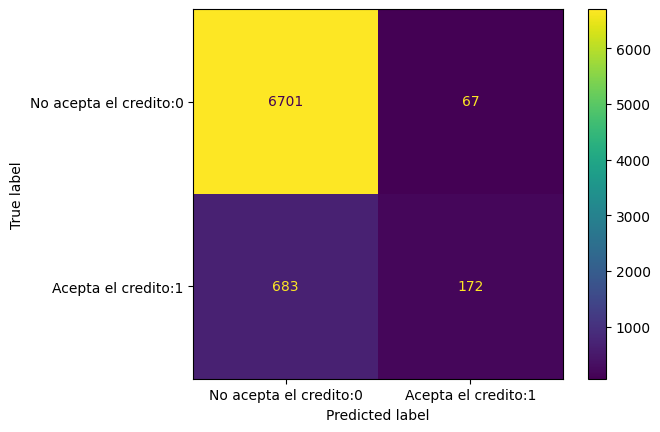

In [38]:
cm = confusion_matrix(y_test, y_pred,labels=mejor_modelo_MLP.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No acepta el credito:0","Acepta el credito:1"])
disp.plot()
plt.show()

In [ ]:
Guardando el modelo

In [40]:
# ruta
ruta_1 = "/home/leomorya/proyecto_final_metodologias/tdsp_template/src"
ruta_2 = "/nombre_paquete/models"
ruta_guarda = f"{ruta_1}{ruta_2}"

joblib.dump(mejor_modelo_MLP, f'{ruta_guarda}/modelo_MLP.pkl')

['/home/leomorya/proyecto_final_metodologias/tdsp_template/src/nombre_paquete/models/modelo_MLP.pkl']

 ### 3. Modelo Maquina de soporte vectorial SVC
---
Los hiperparametros son 

In [41]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [46]:
param_grid_SVC = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, "balanced"],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'random_state': [0, 20, 42]
}


In [47]:
%%time
gsearch = GridSearchCV(
        estimator=SVC(),
        param_grid=param_grid_SVC,
        scoring=make_scorer(f1_score, greater_is_better=True),
        n_jobs=-1,
        cv=10
        ).fit(X_train, y_train)

CPU times: user 8.94 s, sys: 384 ms, total: 9.32 s
Wall time: 57min 50s


Veamos los mejores parametros

In [49]:
gsearch.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'kernel': 'poly', 'random_state': 0}

Imprimamos el reporte

In [50]:
mejor_modelo_SVC = gsearch.best_estimator_
y_pred = mejor_modelo_SVC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90      6768
         1.0       0.36      0.64      0.46       855

    accuracy                           0.83      7623
   macro avg       0.66      0.75      0.68      7623
weighted avg       0.88      0.83      0.85      7623



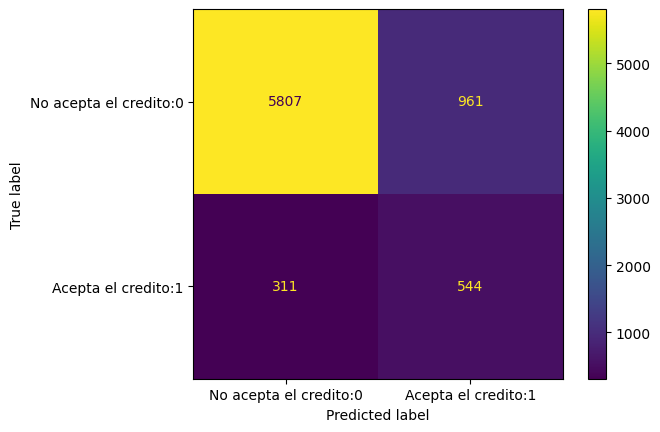

In [51]:
cm = confusion_matrix(y_test, y_pred,labels=mejor_modelo_SVC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No acepta el credito:0","Acepta el credito:1"])
disp.plot()
plt.show()

Guardando el modelo

In [71]:
# ruta
ruta_1 = "/home/leomorya/proyecto_final_metodologias/tdsp_template/src"
ruta_2 = "/nombre_paquete/models"
ruta_guarda = f"{ruta_1}{ruta_2}"

joblib.dump(mejor_modelo_SVC, f'{ruta_guarda}/modelo_SVC.pkl')

['/home/leomorya/proyecto_final_metodologias/tdsp_template/src/nombre_paquete/models/modelo_SVC.pkl']

## resultados y conclusiones
Aqui se presentaran las meticas de cada modelo y se compararan con el modelo base

In [68]:
import pandas as pd

dic_models = {
    ("modelo", ""): ["Regresión Logística", "Random Forest", "Perceptrón Multicapa MLP", "Máquina de Soporte Vectorial SVC"],
    ("Clase Positiva:1", "f1_score"): [0.44, 0.47, 0.31, 0.46],
    ("Clase Positiva:1", "recall"): [0.64, 0.63, 0.20, 0.64],
    ("Clase Positiva:1", "precision"): [0.33, 0.36, 0.72, 0.38],
    ("Clase Positiva:0", "f1_score"): [0.89, 0.91, 0.95, 0.90],
    ("Clase Positiva:0", "recall"): [0.84, 0.87, 0.99, 0.86],
    ("Clase Positiva:0", "precision"): [0.95, 0.95, 0.91, 0.95],
    ("Accuracy", ""): [0.82, 0.84, 0.90, 0.83]
}

columns = pd.MultiIndex.from_tuples(dic_models.keys())
df_metric = pd.DataFrame(dic_models, columns=columns)

In [69]:
df_metric 

modelo Clase Positiva:1                   \
                                            f1_score recall precision   
0               Regresión Logística             0.44   0.64      0.33   
1                     Random Forest             0.47   0.63      0.36   
2          Perceptrón Multicapa MLP             0.31   0.20      0.72   
3  Máquina de Soporte Vectorial SVC             0.46   0.64      0.38   

  Clase Positiva:0                  Accuracy  
          f1_score recall precision           
0             0.89   0.84      0.95     0.82  
1             0.91   0.87      0.95     0.84  
2             0.95   0.99      0.91     0.90  
3             0.90   0.86      0.95     0.83

En el dataframe anterior se muestran las metricas de cada modelo incluyendo el modelbase o modelo base. De lo que se puede concluir:
* El modelo que obtiene una mejor precisión en el perceptron multi capa de 0.72%, que da la probabilidad de que al tomar una muestra positiva generada del modelo este cliente acepte el credito, sin embargo, vemos que el recall y el f1_score son muy bajos lo que muestra que el modelo genera muchos falsos negativos, es decir coloca muchos clientes que aceptaron el credito en la clase donde no se acepta el credito, lo que significa, una gran perdidad de clientes. Por tanto, este modelo no es muy bueno.
* Los modelos de Random forest y la maquina de soporte vectorial presentan las mejores metricas de f_score y recall, obteniendo una precisión de 0.47 y 0.46 respectivamente, que es la probabilidad de que al escojer un cliente de la clase positiva predicha acepte el credito. 
* El modelo de la linea base fue superado por los modelos de Random forest y la maquina de soporte vectorial 
